In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import dataclasses
import json
import os

@dataclasses.dataclass
class Config:
    graph_name: str
    model: str
    lr: str
    
    def get_filename(self):
        return f"{self.graph_name}_{self.model}_{self.lr}.json"
    
    def get_json(self, mode, data_dir="./json"):
        path = os.path.join(data_dir, mode, self.get_filename())
        with open(path, "r") as f:
            return json.load(f)
    
    def get_df(self, mode, data_dir="./json"):
        json_data = self.get_json(mode, data_dir)
        data = [ item for item in json_data["results"] ]
        return pd.DataFrame(data)
    
    def get_pair(self, mode, data_dir="./json"):
        df = self.get_df(mode, data_dir)
        return df['acc_epoch_time'], df['eval_acc']

    
def plot_data(graph_name, mb_df, full_df, max_mb_epoch=-1, max_full_epoch=-1, plotname=None):
    # Create a plot
    plt.figure(figsize=(3, 3))
    
    plt.plot(mb_df['acc_epoch_time'][:max_mb_epoch], mb_df['eval_acc'][:max_mb_epoch], marker='o', markersize=3, linestyle='-', color='b', label="MB")
    plt.plot(full_df['acc_epoch_time'][:max_full_epoch], full_df['eval_acc'][:max_full_epoch], marker='x', linestyle='-', color='r', label="Full")

    # Add labels and title
    plt.xlabel('Time (s)', fontdict={"size": 20})
    plt.ylabel('Accuracy', fontdict={"size": 20})
    if "ogbn-" in graph_name:
        graph_name = graph_name[5:]
    plt.title(f'{graph_name}', fontdict={"size": 20})
    
    # Display the plot
    plt.grid(True)
    plt.legend(loc="lower right", fontsize=14)
    ymin, ymax = plt.ylim()
    plt.ylim(0, min(1, ymax + 0.25))
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    if plotname:
        os.makedirs("plot", exist_ok=True)
        plt.tight_layout()
        plt.savefig(f"./plot/{plotname}")
    plt.show()

def plot_data_multi(graph_names, plot_name=None):
    # Update the global font family to sans-serif
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans']  # Or any other sans-serif font installed on your system
    })
    nplot = len(graph_names)
    fig, axes = plt.subplots(1, nplot, figsize=(8, 3), sharex=False, sharey=True)
    
    def plot_data(idx, graph_name, mb_df, full_df, max_mb_epoch=-1, max_full_epoch=-1):
        ax = axes[idx]
        ax.plot(mb_df['acc_epoch_time'][:max_mb_epoch], mb_df['eval_acc'][:max_mb_epoch], marker='o', markersize=3, linestyle='-', color='r', label="MB")
        ax.plot(full_df['acc_epoch_time'][:max_full_epoch], full_df['eval_acc'][:max_full_epoch], marker='x', linestyle='-', color='b', label="Full")
    
        if "ogbn-" in graph_name:
            graph_name = graph_name[5:]
        ax.set_title(f'{graph_name}', fontdict={"size": 20})
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)

        if idx == 0:
            ax.set_ylabel("Accuracy", fontsize=20)
        if idx == 1:
            ax.set_xlabel("                    Time (s)", fontsize=20)
        if idx == 0:
            ax.legend(loc="lower right", fontsize=15)
        # Display the plot
        ax.grid(True)
    
    for idx, graph_name in enumerate(graph_names):
        mb_conf = Config(graph_name=graph_name, model="sage", lr="0.003")
        mb_df = mb_conf.get_df("train_minibatch", "backup_v4/json")
        full_conf = Config(graph_name=graph_name, model="sage", lr="0.003")
        full_df = full_conf.get_df("train_full", "backup_v4/json")
        
        mb_best_eval_idx = mb_df["eval_acc"].idxmax()
        full_best_eval_idx = full_df["eval_acc"].idxmax()
        mb_best_eval_idx = min(5, mb_best_eval_idx)
        full_best_eval_idx = min(30, full_best_eval_idx)
        plot_data(idx, graph_name, mb_df, full_df, mb_best_eval_idx, full_best_eval_idx)
    fig.tight_layout()

    if plot_name:
        fig.savefig(f"{plot_name}")
    fig.show()
    

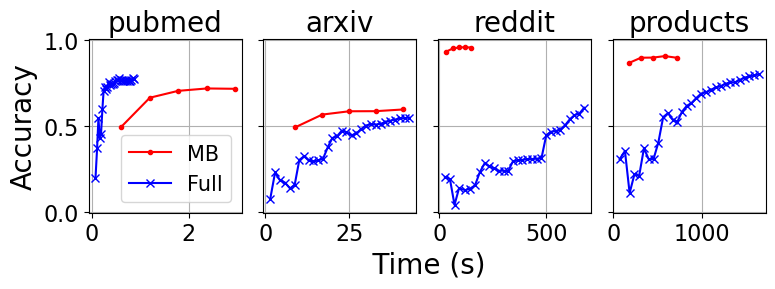

In [30]:
graph_names = ["pubmed", "ogbn-arxiv", "reddit", "ogbn-products"]
plot_data_multi(graph_names, "plot/mb_vs_full_cpu.pdf")

In [8]:
# graph_names = ["pubmed", "ogbn-arxiv", "reddit", "ogbn-products"]
graph_names = ["pubmed"]

for graph_name in graph_names:
    mb_conf = Config(graph_name=graph_name, model="sage", lr="0.003")
    mb_df = mb_conf.get_df("train_full", "backup_v4/json")
    best_eval_idx = mb_df["eval_acc"].idxmax()
    row = mb_df.loc[best_eval_idx]
    
    def get_mean(df, idx, col, round_to=2):
        return round(df.loc[:idx, col].mean(), round_to)

    sample_time = 0
    # sample_time = get_mean(mb_df, best_eval_idx, "sample_time")
    # sample_time += get_mean(mb_df, best_eval_idx, "load_time")
    
    fb_time = get_mean(mb_df, best_eval_idx, "forward_time")
    fb_time += get_mean(mb_df, best_eval_idx, "backward_time")
    
    epoch_time = get_mean(mb_df, best_eval_idx, "cur_epoch_time")
    
    tta = round(row["acc_epoch_time"], 1)
    
    print(f"{graph_name=} {sample_time=} {fb_time=} {epoch_time=} {tta=} ")

graph_name='pubmed' sample_time=0 fb_time=0.02 epoch_time=0.03 tta=2.4 


In [9]:
best_eval_idx

86

In [167]:

# for graph_name in graph_names:
#     mb_conf = Config(graph_name=graph_name, model="sage", lr="0.003")
#     mb_df = mb_conf.get_df("train_minibatch", "backup_v4/json")
#     full_conf = Config(graph_name=graph_name, model="sage", lr="0.003")
#     full_df = full_conf.get_df("train_full", "backup_v4/json")
#     plot_data(graph_name, mb_df, full_df, 3, 35, f"{graph_name}_mb_vs_full_cpu.pdf")